# micapipe v0.2.0 | Group QC

In [4]:
from xhtml2pdf import pisa
import sys
import pandas as pd
import numpy as np
import os
import glob
import json
import nibabel as nb
from brainspace.mesh.mesh_io import read_surface
from brainspace.plotting import plot_hemispheres
out = '/data_/mica3/BIDS_PNI/derivatives/micapipe_v0.2.0'
# Set dataset PNI as working directory
os.chdir(out)

# Load native mid surface
micapipe='/data_/mica1/01_programs/micapipe-v0.2.0'
inf_lh = read_surface(micapipe + '/surfaces/fsLR-32k.L.inflated.surf.gii', itype='gii')
inf_rh = read_surface(micapipe + '/surfaces/fsLR-32k.R.inflated.surf.gii', itype='gii')

def plot_connectome(mtx, Title='matrix plot', xlab='X', ylab='Y', col='rocket', vmin=None, vmax=None,
                   xticklabels='auto', yticklabels='auto',xrot=90, yrot=0):
    
    '''
    This optional function, only plots a connectome as a heatmap
    Parameters
    ----------
    mtx : np.array
    Returns
    -------
    f : plot
    '''
    f, ax = plt.subplots(figsize=(15,10))
    g = sns.heatmap(mtx, ax=ax, cmap=col, vmin=vmin, vmax=vmax, xticklabels=xticklabels, yticklabels=yticklabels)
    g.set_xlabel(xlab)
    g.set_ylabel(ylab)
    g.set_title(Title)
    # Rotate the x-axis labels
    # rotate tick labels
    ax.set_xticklabels(ax.get_xticklabels(), rotation=xrot, ha='right')
    ax.set_yticklabels(ax.get_yticklabels(), rotation=yrot, ha='right')

def upper_tri_indexing(A):
    m = A.shape[0]
    r,c = np.triu_indices(m,1)
    return A[r,c]

def load_mpc(File, Ndim):
    """Loads and process a MPC"""
    
    # load the matrix
    mtx_mpc = np.loadtxt(File, dtype=float, delimiter=' ')
    
    # Mirror the matrix
    MPC = np.triu(mtx_mpc,1)+mtx_mpc.T
    
    # Remove the medial wall
    MPC = np.delete(np.delete(MPC, 0, axis=0), 0, axis=1)
    MPC = np.delete(np.delete(MPC, Ndim, axis=0), Ndim, axis=1)
    
    return MPC

def load_gd(File, Ndim):
    """Loads and process a GD"""
    
    # load the matrix
    mtx_gd = np.loadtxt(File, dtype=float, delimiter=' ')
    
    # Remove the Mediall Wall
    mtx_gd = np.delete(np.delete(mtx_gd, 0, axis=0), 0, axis=1)
    GD = np.delete(np.delete(mtx_gd, Ndim, axis=0), Ndim, axis=1)
    
    return GD

def load_fc(File, Ndim, parc=''):
    """Loads and process a functional connectome"""
    
    # load the matrix
    mtx_fs = np.loadtxt(File, dtype=float, delimiter=' ')
    
    # slice the matrix remove subcortical nodes and cerebellum
    FC = mtx_fs[49:, 49:]
    
    # Remove the medial wall
    #if parc != 'glasser-360':
    #    FC = np.delete(np.delete(FC, Ndim, axis=0), Ndim, axis=1)
    
    # Fishcer transform
    FCz = np.arctanh(FC)

    # replace inf with 0
    FCz[~np.isfinite(FCz)] = 0
    
    # Mirror the matrix
    FCz = np.triu(FCz,1)+FCz.T
    return FCz

def load_sc(File, Ndim):
    """Loads and process a structura connectome"""
    
    # load the matrix
    mtx_sc = np.loadtxt(File, dtype=float, delimiter=' ')
    
    # Mirror the matrix
    mtx_sc = np.log(np.triu(mtx_sc,1)+mtx_sc.T)
    mtx_sc[np.isneginf(mtx_sc)] = 0
    
    # slice the matrix remove subcortical nodes and cerebellum
    SC = mtx_sc[49:, 49:]
    SC = np.delete(np.delete(SC, Ndim, axis=0), Ndim, axis=1)
    
    # replace 0 values with almost 0
    SC[SC==0] = np.finfo(float).eps
    
    return SC

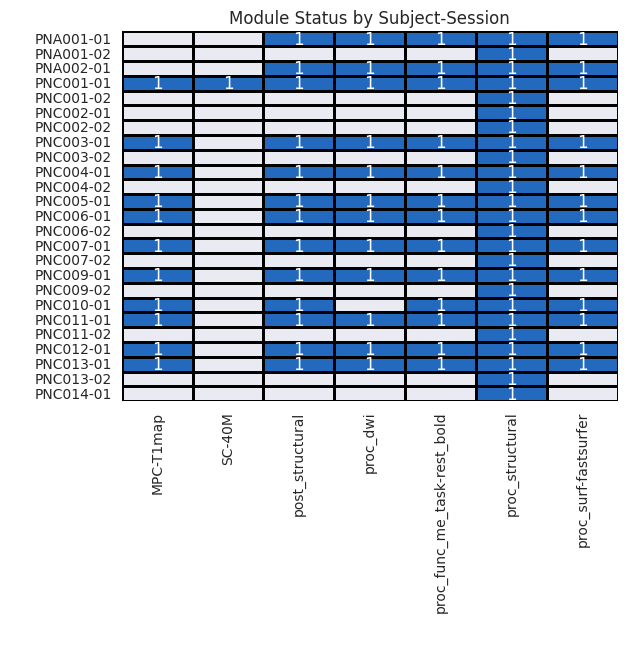

In [5]:
# Arguments
sub = 'HC062'
bids = '/data_/mica3/BIDS_PNI/rawdata'
#out = '/data_/mica3/BIDS_MICs/derivatives/micapipe_v0.2.0'
#bids = '/data_/mica3/BIDS_MICs/rawdata'
ses = '01'
tmpDir = '/tmp/'
version = 'v0.2.0'

# Optional inputs:
# Session
if ses == "":
    ses_number = "Not defined"
    sbids = sub
else:
    ses_number = ses
    ses = "ses-" + ses_number
    sbids = sub + "_" + ses

derivatives = out.split('/micapipe_v0.2.0')[0]

# Path to MICAPIPE
MICAPIPE=os.popen("echo $MICAPIPE").read()[:-1]

# List all the jsons
if ses_number == "Not defined":
    jsons = sorted(glob.glob(out+'/sub*/QC/*json'))
else:
    jsons = sorted(glob.glob(out+'/sub*/ses*/QC/*json'))

# Sort the JSON files by creation time (newest at the bottom)
jsons = sorted(jsons, key=lambda x: os.path.getctime(x))
                   
# Define the keys to extract from each JSON file
keys_to_extract = ['Subject', 'Session', 'Module', 'Status', 'Progress', 'User', 'Workstation', 'Date', 'Processing.time', 'Processing', 'micapipeVersion']

# Initialize an empty list to hold the individual dataframes
dataframes = []

# Loop through each JSON file in the specified directory
for file_name in jsons:

    # Read in the JSON data from the file
    with open(file_name, 'r') as f:
        json_data = json.load(f)

    # Extract the desired keys and create a dataframe
    data = {k: [] for k in keys_to_extract}
    
    for k in keys_to_extract:
        data[k].append(json_data[k])

    df = pd.DataFrame(data)

    # Append the dataframe to the list
    dataframes.append(df)

# Concatenate all the individual dataframes into a single dataframe
result = pd.concat(dataframes, ignore_index=True)

# Rename Version column
result.rename(columns={'micapipeVersion': 'Version'})

# Save the resulting dataframe as a CSV file
result.to_csv(out+'/micapipe_processed_sub.csv', index=False)

# --------------------------------------------------------
# Create an empty dictionary to hold the data
data = {}

# Loop through each row in the concatenated dataframe
for i in range(len(result)):

    # Extract thesubject and session and module and status from the row
    subject = result['Subject'][i]
    session = result['Session'][i]
    module = result['Module'][i]
    status = result['Status'][i]

    # Convert the status to a binary value
    if status == 'INCOMPLETE':
        value = 0
    elif status == 'COMPLETED':
        value = 1
    else:
        value = np.nan

    # Add the value to the data dictionary
    key = f"{subject}-{session}"
    if key not in data:
        data[key] = {}
    data[key][f"{module}"] = value

# Create a dataframe from the data dictionary
df = pd.DataFrame(data).T

# Sort the columns by module and status
df = df.reindex(sorted(df.columns), axis=1)

# Sort the rows by subject and session
df = df.sort_index()

import seaborn as sns
import matplotlib.pyplot as plt

# background
sns.set_style('dark')
sns.heatmap(df, cmap='vlag', annot=True, cbar=False, fmt='.0f', linewidths=1, linecolor='black', annot_kws={'fontsize':12, 'color':'white'})

# Set the x and y axis labels to white
plt.xlabel('Module-Status', fontsize=14, color='white')
plt.ylabel('Subject-Session', fontsize=14, color='white')

# Set the plot title and axis labels
plt.title('Module Status by Subject-Session')
plt.xlabel('Module-Status')
plt.ylabel('Subject-Session')

# Rotate the x-axis labels for better visibility
plt.xticks(rotation=90)
plt.yticks(rotation=0)

# Display the plot
plt.show()

In [6]:
# Get progress percentage
module_progress = np.sum(df, axis=0)/len(df)

Text(0.5, 1.0, 'Module Progress')

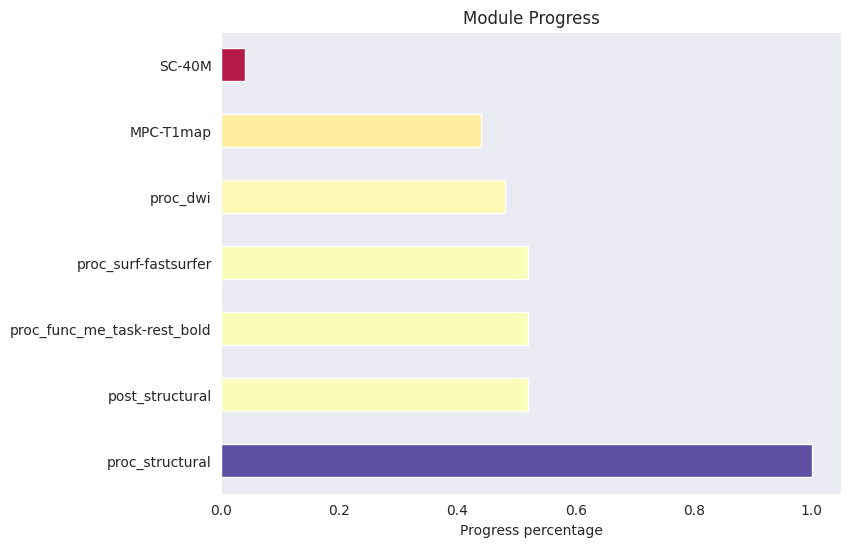

In [7]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.cm import Spectral

# sort the series by values
module_progress_sorted = module_progress.sort_values(ascending=False)

# create the horizontal barplot
fig, ax = plt.subplots(figsize=(8, 6))
module_progress_sorted.plot.barh(ax=ax, color=Spectral(module_progress_sorted))

# set the x and y axis labels and title
ax.set_xlabel('Progress percentage')
ax.set_title('Module Progress')


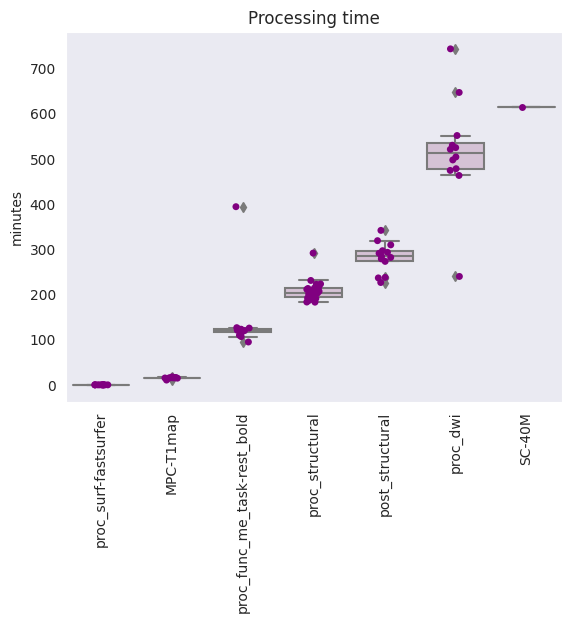

In [8]:
# Convert the processing.time to numeric
result['Processing.time'] = pd.to_numeric(result['Processing.time'])

# Calculate the mean and standard deviation by module and sort by mean processing time
stats_df = result.groupby('Module')['Processing.time'].agg(['mean', 'std'])
stats_df = stats_df.sort_values('mean')
stats_df['mean_std'] = stats_df.apply(lambda row: '{:.2f} +/- {:.2f}'.format(row['mean'], row['std']), axis=1)
stats_df = stats_df.reset_index()

# Create the box plot with custom box and whisker colors and sorted order
sns.boxplot(x='Module', y='Processing.time', data=result, order=stats_df['Module'], color='thistle')

# Add the individual data points as dots
sns.stripplot(x='Module', y='Processing.time', data=result, order=stats_df['Module'], color='purple')

# Set the title of the plot
plt.title('Processing Time')

# Rotate the x-axis labels
plt.xticks(rotation=90)
# labels
plt.xlabel('')
plt.ylabel('minutes')
plt.title('Processing time')

# Show the plot
plt.show()

In [9]:
# Calculate the mean and standard deviation by module and sort by mean processing time
stats_df = result.groupby('Module')['Processing.time'].agg(['mean', 'std'])
stats_df = stats_df.sort_values('mean')
stats_df['mean_std'] = stats_df.apply(lambda row: '{:.1f} ± {:.1f}'.format(row['mean'], row['std']), axis=1)

# Print the table as a pandas dataframe
stats_df[['mean_std']]

mean_std
Module                                    
proc_surf-fastsurfer             0.0 ± 0.0
MPC-T1map                       15.3 ± 1.8
proc_func_me_task-rest_bold   138.7 ± 77.2
proc_structural               207.6 ± 21.6
post_structural               282.2 ± 33.3
proc_dwi                     514.4 ± 117.9
SC-40M                         615.4 ± nan

# Maps: vertex-wise  surfaces
# Thickness group level cortical thickness

In [10]:
# change working directory
os.chdir(out)
os.getcwd()

'/data_/mica3/BIDS_PNI/derivatives/micapipe_v0.2.0'

In [11]:
# Load all the cortical thickness
th_lh_files=sorted(glob.glob('sub-*/ses-*/maps/*_hemi-L_surf-fsLR-32k_label-thickness.func.gii'))
th_rh_files=sorted(glob.glob('sub-*/ses-*/maps/*_hemi-R_surf-fsLR-32k_label-thickness.func.gii'))

# get the BIDS ids
bids_ids = [elem.split('/')[0] + '_' + elem.split('/')[1] for elem in th_lh_files]

# Load all the thickness data
Nth=np.concatenate((nb.load(th_lh_files[0]).darrays[0].data, nb.load(th_rh_files[0]).darrays[0].data), axis=0).shape[0]

th=np.empty([len(th_lh_files), Nth], dtype=float)
for i, f in enumerate(th_lh_files):
    #print(f)
    th[i,:] = np.hstack(np.concatenate((nb.load(th_lh_files[i]).darrays[0].data, nb.load(th_rh_files[i]).darrays[0].data), axis=0))

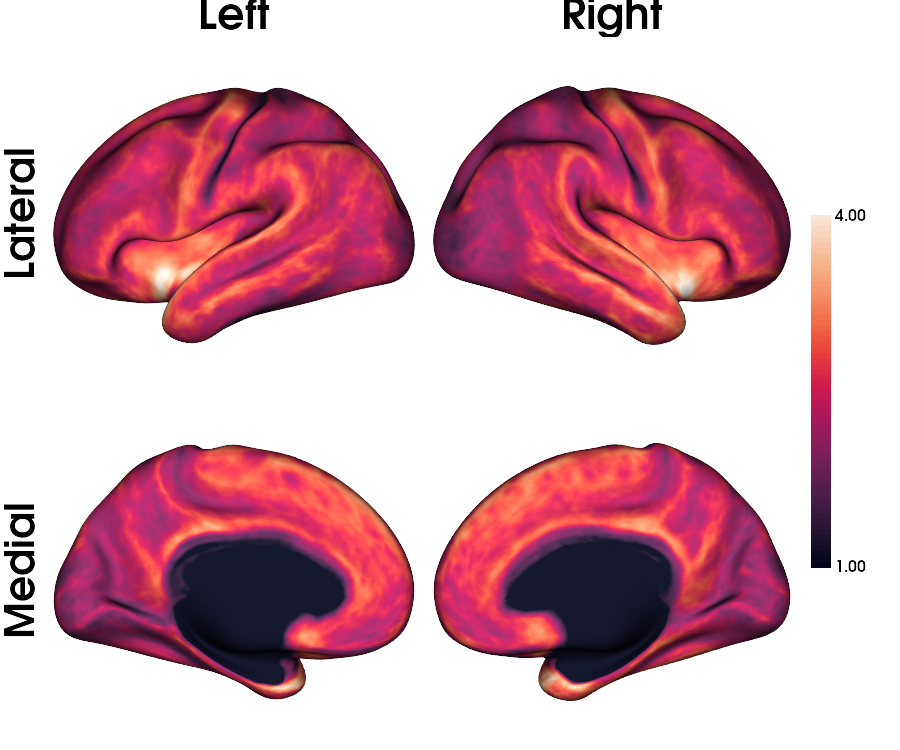

In [12]:
# Mean matrix across the x axis (vertices)
thmean = np.mean(th, axis=0)

# Plot the mean thickness 10mm on conte69 surface
plot_hemispheres(inf_lh, inf_rh, array_name=thmean, cmap='rocket', nan_color=(0, 0, 0, 1),
                      zoom=1.3, size=(900, 750), embed_nb=True,
                      color_bar='right', layout_style='grid', color_range=(1, 4),
                      label_text={'left': ['Lateral', 'Medial'], 'top': ['Left', 'Right']},
                      screenshot=False, filename='/home/bic/rcruces/Desktop/PNI_thickness_mean.png')

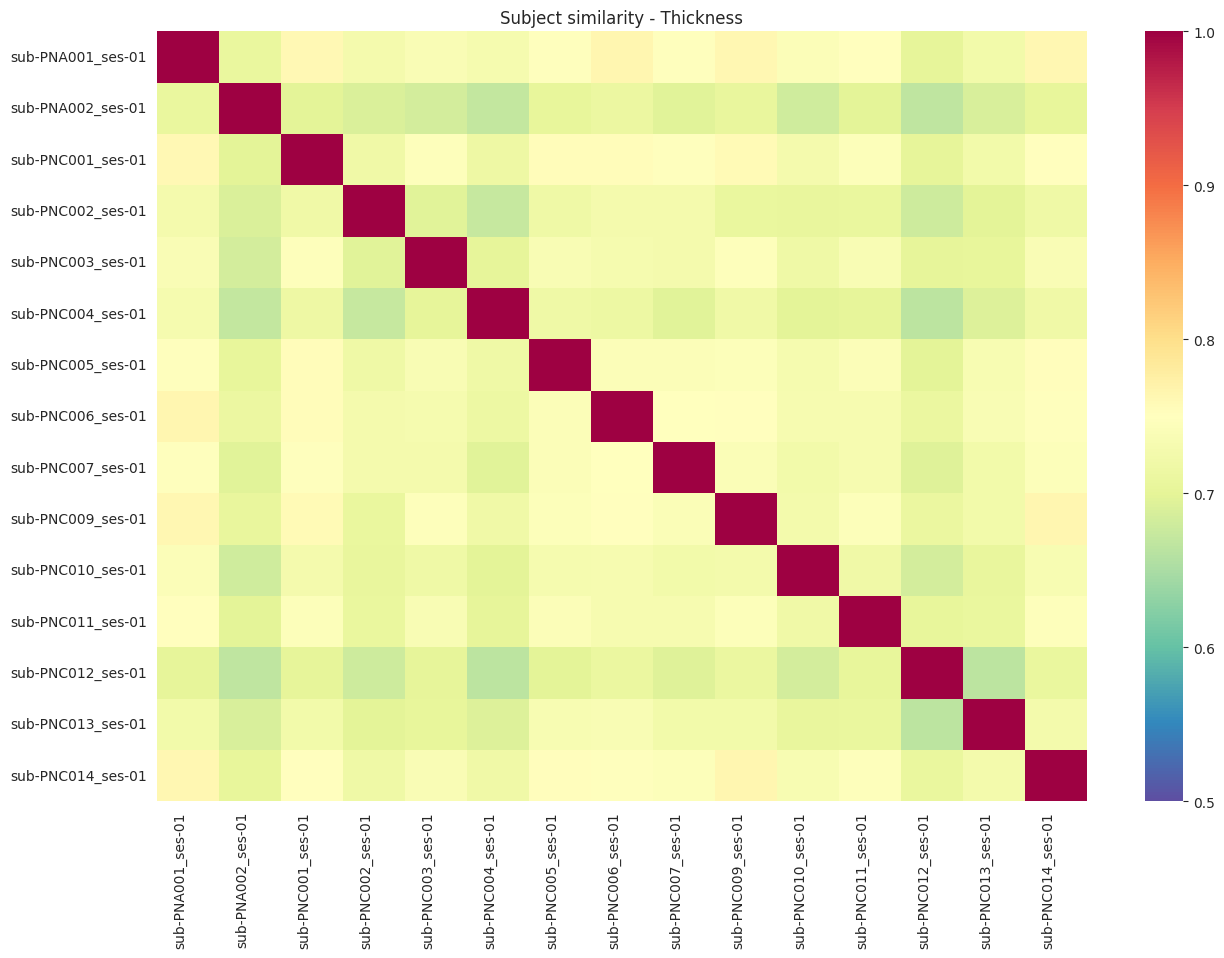

In [13]:
## correlation matrix
th_corr = np.corrcoef(th)
plot_connectome(th_corr, 'Subject similarity - Thickness', xlab=None, ylab=None, col='Spectral_r', vmin=0.5, vmax=1,
               yticklabels=bids_ids, xticklabels=bids_ids)


# DWI maps

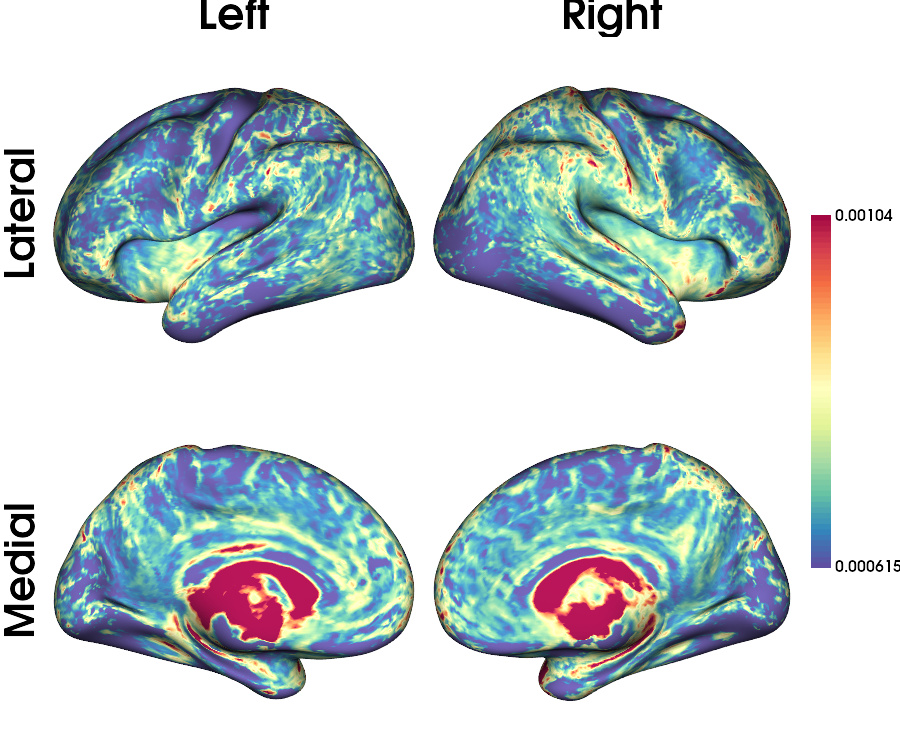

In [14]:
# Load all the cortical thickness
Map='ADC'
fl_lh_files=sorted(glob.glob('sub-*/ses-*/maps/*_hemi-L_surf-fsLR-32k_label-midthickness_'+Map+'.func.gii'))
fl_rh_files=sorted(glob.glob('sub-*/ses-*/maps/*_hemi-R_surf-fsLR-32k_label-midthickness_'+Map+'.func.gii'))

# get the BIDS ids
bids_ids = [elem.split('/')[0] + '_' + elem.split('/')[1] for elem in fl_lh_files]

# Load all the thickness data
Nfl=np.concatenate((nb.load(fl_lh_files[0]).darrays[0].data, nb.load(fl_rh_files[0]).darrays[0].data), axis=0).shape[0]

fl=np.empty([len(fl_lh_files), Nfl], dtype=float)
for i, f in enumerate(fl_lh_files):
    fl[i,:] = np.hstack(np.concatenate((nb.load(fl_lh_files[i]).darrays[0].data, nb.load(fl_rh_files[i]).darrays[0].data), axis=0))

# Mean matrix across the x axis (vertices)
flmean = np.mean(fl, axis=0)

# Plot the mean thickness 10mm on conte69 surface
Range=(np.quantile(flmean, 0.15), np.quantile(flmean, 0.98))
plot_hemispheres(inf_lh, inf_rh, array_name=flmean, cmap='Spectral_r', nan_color=(0, 0, 0, 1),
                      zoom=1.3, size=(900, 750), embed_nb=True,
                      color_bar='right', layout_style='grid', color_range=Range,
                      label_text={'left': ['Lateral', 'Medial'], 'top': ['Left', 'Right']},
                      screenshot=False, filename='/home/bic/rcruces/Desktop/PNI_'+Map+'_mean.png')


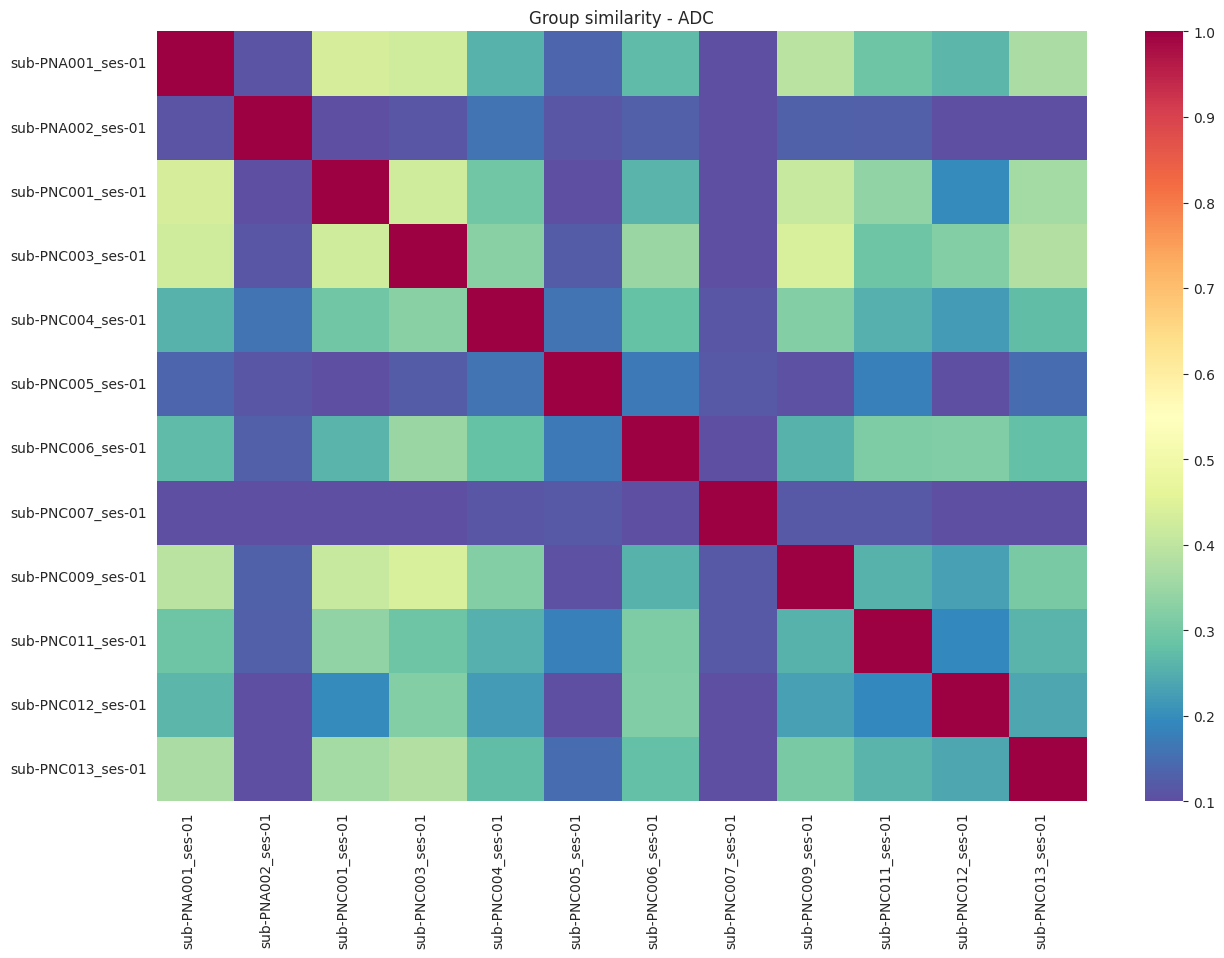

In [16]:
## correlation matrix
fl_corr = np.corrcoef(fl)
plot_connectome(fl_corr, 'Group similarity - '+Map, xlab=None, ylab=None, col='Spectral_r', vmin=0.1, vmax=1,
               yticklabels=bids_ids, xticklabels=bids_ids)


# proc_func

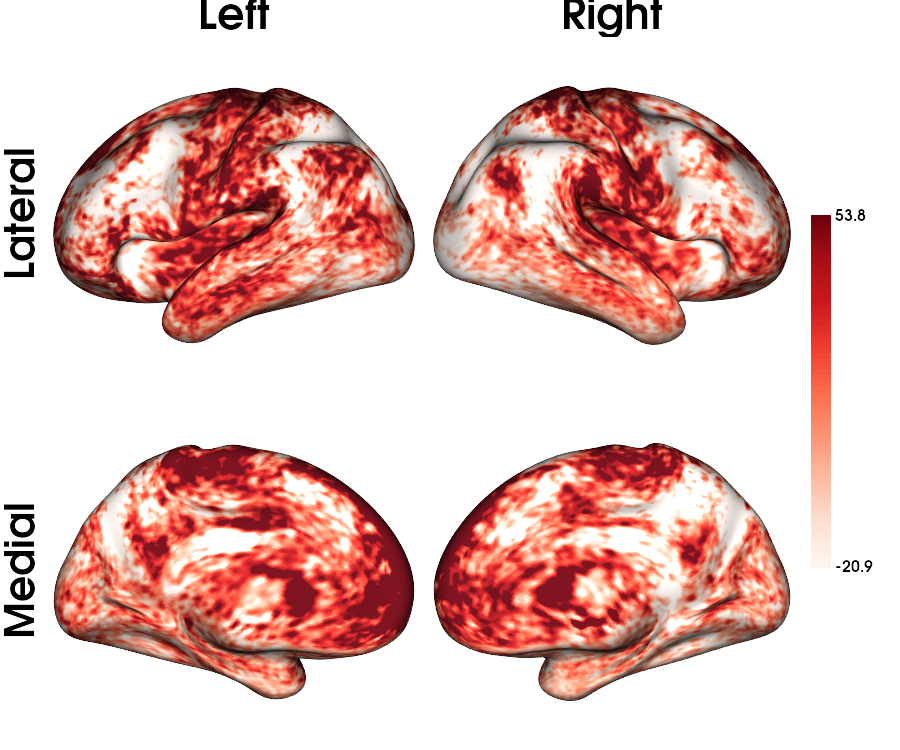

In [17]:
# Get the unique func acquisition strings and for each func acq string run:
# func_acq='se_task-rest_acq-AP_bold'
func_acq='me_task-rest_bold'

# Load all the func 
fc_lh_files=sorted(glob.glob('sub-*/ses-*/func/desc-'+func_acq+'/surf/*_hemi-L_surf-fsLR-32k.func.gii'))
fc_rh_files=sorted(glob.glob('sub-*/ses-*/func/desc-'+func_acq+'/surf/*_hemi-R_surf-fsLR-32k.func.gii'))

# get the BIDS ids
bids_ids = [elem.split('/')[0] + '_' + elem.split('/')[1] for elem in fc_lh_files]

def load_func_gii(func_L, func_R):
    func_data = np.concatenate((nb.load(func_L).darrays[0].data, 
                              nb.load(func_R).darrays[0].data), axis=0)
    return(func_data)
    
# Load all the func data
Nfc=load_func_gii(fc_lh_files[0], fc_rh_files[0]).shape[0]
fc=np.empty([len(fc_lh_files), Nfc], dtype=float)
for i, f in enumerate(fc_lh_files):
    fc[i,:] = load_func_gii(fc_lh_files[i], fc_rh_files[i])

# Mean matrix across the x axis (vertices)
fcmean = np.mean(fc, axis=0)

# Plot the mean func
Range=(np.quantile(fcmean, 0.10), np.quantile(fcmean, 0.9))
plot_hemispheres(inf_lh, inf_rh, array_name=fcmean, cmap='Reds', nan_color=(0, 0, 0, 1),
                      zoom=1.3, size=(900, 750), embed_nb=True,
                      color_bar='right', layout_style='grid', color_range=Range,
                      label_text={'left': ['Lateral', 'Medial'], 'top': ['Left', 'Right']},
                      screenshot=False, filename='/home/bic/rcruces/Desktop/PNI_func_mean.png')

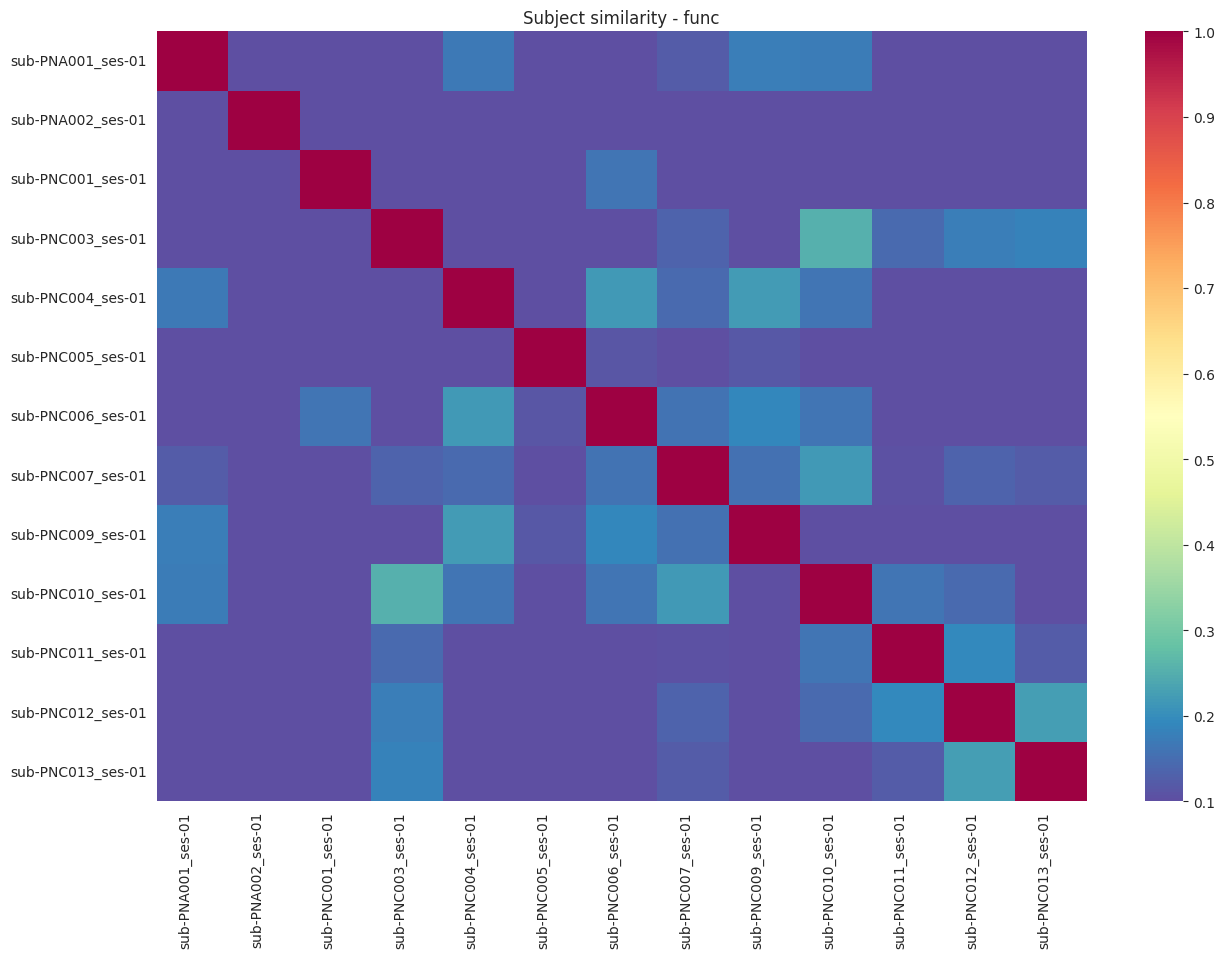

In [18]:
## correlation matrix
fc_corr = np.corrcoef(fc)
plot_connectome(fc_corr, 'Subject similarity - func', xlab=None, ylab=None, col='Spectral_r', vmin=0.1, vmax=1,
               yticklabels=bids_ids, xticklabels=bids_ids)


# flair

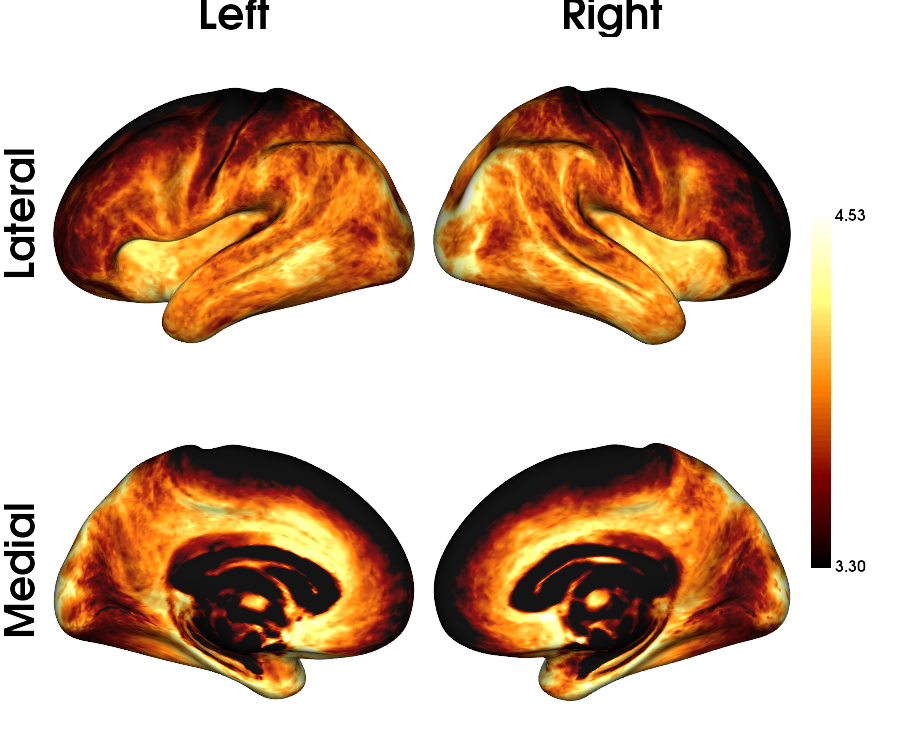

In [218]:
# Load all the flair 
fl_lh_files=sorted(glob.glob('sub-*/ses-*/maps/*_hemi-L_surf-fsLR-32k_label-midthickness_flair.func.gii'))
fl_rh_files=sorted(glob.glob('sub-*/ses-*/maps/*_hemi-R_surf-fsLR-32k_label-midthickness_flair.func.gii'))

# get the BIDS ids
bids_ids = [elem.split('/')[0] + '_' + elem.split('/')[1] for elem in fl_lh_files]

# Load all the thickness data
Nfl=np.concatenate((nb.load(fl_lh_files[0]).darrays[0].data, nb.load(fl_rh_files[0]).darrays[0].data), axis=0).shape[0]

fl=np.empty([len(fl_lh_files), Nfl], dtype=float)
for i, f in enumerate(fl_lh_files):
    fl[i,:] = np.hstack(np.concatenate((nb.load(fl_lh_files[i]).darrays[0].data, nb.load(fl_rh_files[i]).darrays[0].data), axis=0))

# Mean matrix across the x axis (vertices)
flmean = np.mean(fl, axis=0)

# Plot the mean thickness 10mm on conte69 surface
Range=(np.quantile(flmean, 0.15), np.quantile(flmean, 0.999))
plot_hemispheres(inf_lh, inf_rh, array_name=flmean, cmap='afmhot', nan_color=(0, 0, 0, 1),
                      zoom=1.3, size=(900, 750), embed_nb=True,
                      color_bar='right', layout_style='grid', color_range=Range,
                      label_text={'left': ['Lateral', 'Medial'], 'top': ['Left', 'Right']},
                      screenshot=False, filename='/home/bic/rcruces/Desktop/PNI_flair_mean.png')


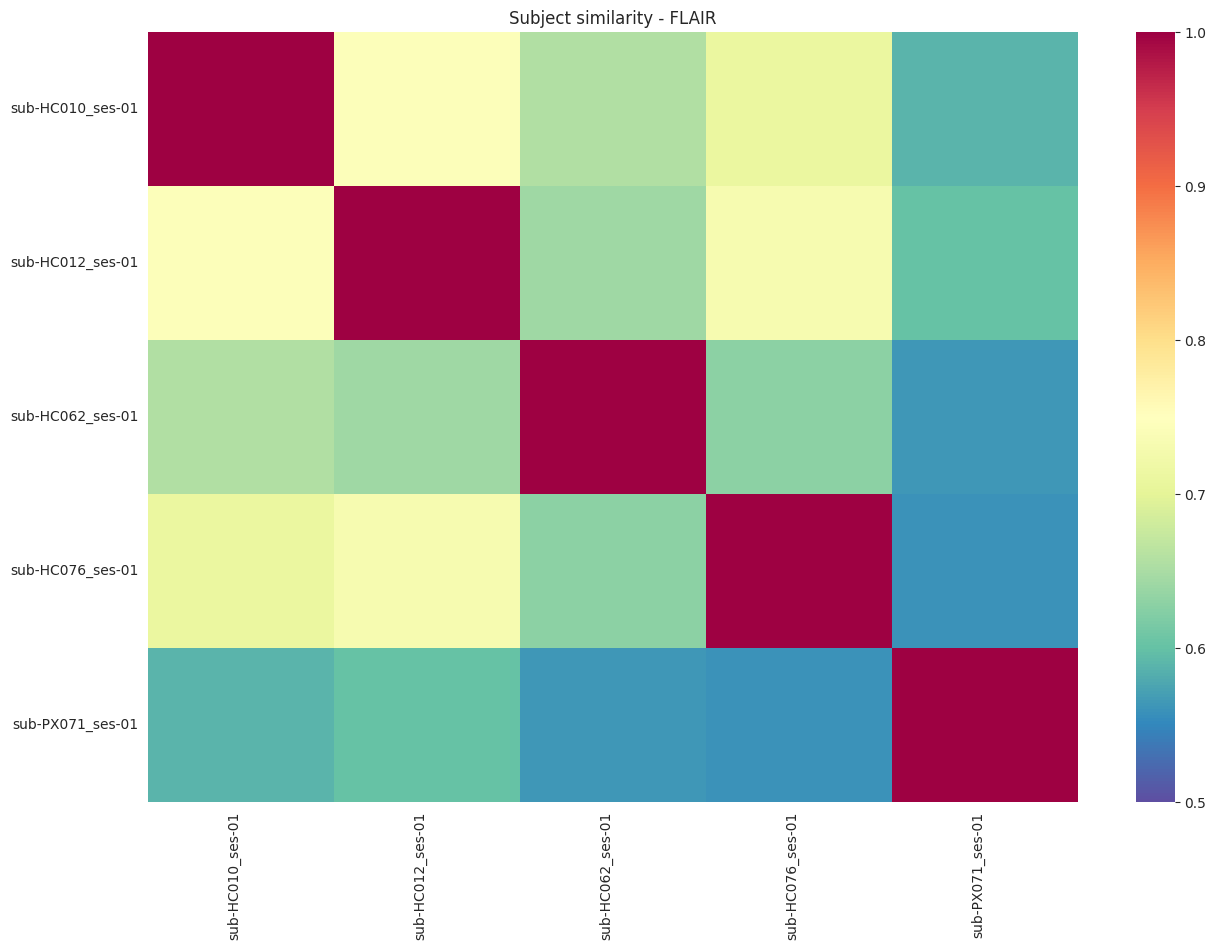

In [219]:
## correlation matrix
fl_corr = np.corrcoef(fl)
plot_connectome(fl_corr, 'Subject similarity - FLAIR', xlab=None, ylab=None, col='Spectral_r', vmin=0.5, vmax=1,
               yticklabels=bids_ids, xticklabels=bids_ids)


In [322]:
def zscore_mtx(sim_mtx):
    # set the diagonal elements to zero
    np.fill_diagonal(sim_mtx, 0)
    # mean of the subjects
    vec = np.mean(sim_mtx,axis=1)
    # get the upper triangle values mean and standard deviation
    utri = upper_tri_indexing(sim_mtx)
    utri_m = np.mean(utri)
    utri_s = np.std(utri)
    # Calculate the zscore of each value
    zvec = (vec-utri_m)/utri_s
    return(vec,zvec)

zscore_mtx(fl_corr)

(array([0.53930404, 0.54308868, 0.49737314, 0.52536924, 0.46231201]),
 array([-1.60699419, -1.54769195, -2.26401646, -1.82534088, -2.81339497]))

In [359]:
# Load files
def load_connectomes(files, Ndim, func):
    # Load all the matrices
    M=np.empty([Ndim*2, Ndim*2, len(files)], dtype=float)
    for i, f in enumerate(files):
        M[:,:,i] = func(f, Ndim)
        
    return M

# Load annotation file in fsaverage5
atlas='schaefer-400'
annot_lh_fs5= nb.freesurfer.read_annot(micapipe + '/parcellations/lh.' + atlas + '_mics.annot')
Ndim = max(np.unique(annot_lh_fs5[0]))

# Read label for conte69
labels_c69 = np.loadtxt(open(micapipe + '/parcellations/'+atlas+'_conte69.csv'), dtype=int)

# mask of the medial wall
mask_c69 = labels_c69 != 0

from brainspace.utils.parcellation import map_to_labels

# ROI based connectomes: schaefer-400
# GD

In [364]:
# Load all the connectomes
files=sorted(glob.glob('sub-*/ses-*/dist/*_atlas-schaefer-400_GD.txt'))

GD = load_connectomes(files, Ndim, load_gd)

# Mean matrix across the z axis (subjects)
gd_mean = np.mean(GD, axis=2)
# Mean acros columns
gd_colM = np.mean(gd_mean, axis=1)
# map to labels
gd_surf = map_to_labels(gd_colM, labels_c69, fill=np.nan, mask=mask_c69)

In [376]:
if len(files) == 0: print('No files were found')

No files were found


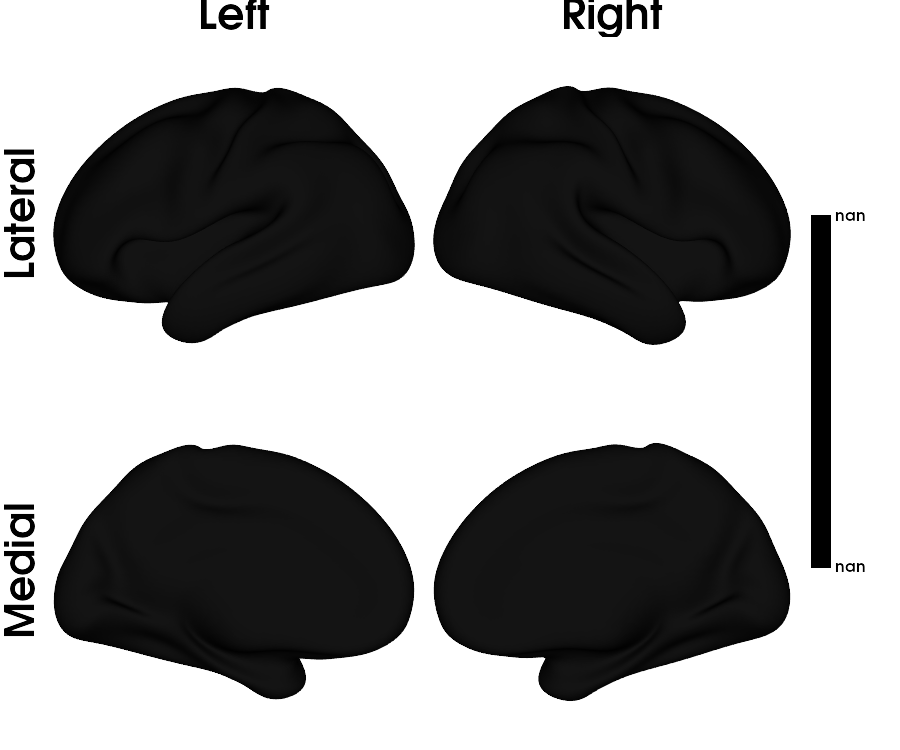

In [365]:
# Plot the mean GD
plot_hemispheres(inf_lh, inf_rh, array_name=gd_surf, cmap='vlag', nan_color=(0, 0, 0, 1),
                      zoom=1.3, size=(900, 750), embed_nb=True,
                      color_bar='right', layout_style='grid', color_range='sym',
                      label_text={'left': ['Lateral', 'Medial'], 'top': ['Left', 'Right']},
                      screenshot=False, filename='/home/bic/rcruces/Desktop/GD_mean_schaefer-400.png')

/host/yeatman/local_raid/rcruces/anaconda3/lib/python3.9/site-packages/seaborn/matrix.py:305: UserWarning: Attempting to set identical left == right == 0 results in singular transformations; automatically expanding.
  ax.set(xlim=(0, self.data.shape[1]), ylim=(0, self.data.shape[0]))
/host/yeatman/local_raid/rcruces/anaconda3/lib/python3.9/site-packages/seaborn/matrix.py:305: UserWarning: Attempting to set identical bottom == top == 0 results in singular transformations; automatically expanding.
  ax.set(xlim=(0, self.data.shape[1]), ylim=(0, self.data.shape[0]))


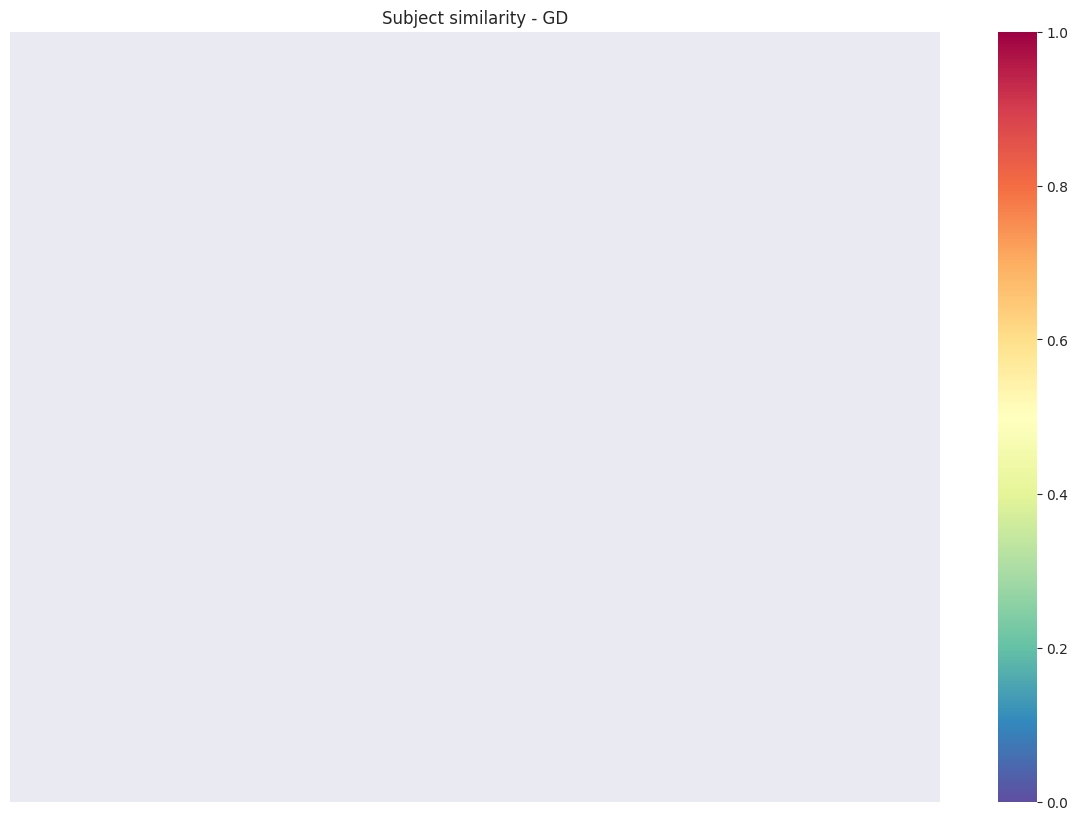

In [366]:
# get the BIDS ids
bids_ids = [elem.split('/')[0] + '_' + elem.split('/')[1] for elem in files]

cn_corr = np.corrcoef(np.mean(GD, axis=1).T)
plot_connectome(cn_corr, 'Subject similarity - GD', xlab=None, ylab=None, col='Spectral_r', vmin=0, vmax=1,
               yticklabels=bids_ids, xticklabels=bids_ids)

# SC

In [327]:
# Load all the connectomes
files=sorted(glob.glob('sub-*/ses-*/dwi/connectomes/*atlas-schaefer-400_desc-iFOD2-40M-SIFT2_full-connectome.txt'))

SC = load_connectomes(files, Ndim, load_sc)

# Mean matrix across the z axis (subjects)
cn_mean = np.mean(SC, axis=2)
# Mean acros columns
cn_colM = np.mean(cn_mean, axis=1)
# map to labels
cn_surf = map_to_labels(cn_colM, labels_c69, fill=np.nan, mask=mask_c69)


/host/yeatman/local_raid/temporaryLocalProcessing/ipykernel_9539/1146255709.py:104: RuntimeWarning: divide by zero encountered in log
  mtx_sc = np.log(np.triu(mtx_sc,1)+mtx_sc.T)


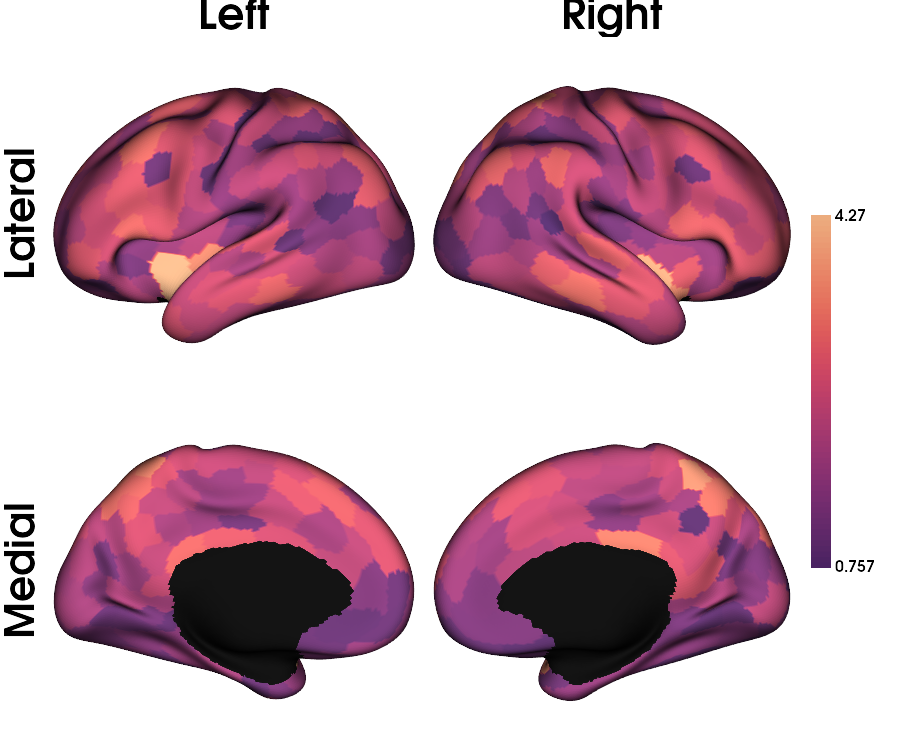

In [328]:
# Plot the mean SC
plot_hemispheres(inf_lh, inf_rh, array_name=cn_surf, cmap='flare_r', nan_color=(0, 0, 0, 1),
                      zoom=1.3, size=(900, 750), embed_nb=True,
                      color_bar='right', layout_style='grid', color_range='sym',
                      label_text={'left': ['Lateral', 'Medial'], 'top': ['Left', 'Right']},
                      screenshot=False, filename='/home/bic/rcruces/Desktop/SC_mean_schaefer-400.png')

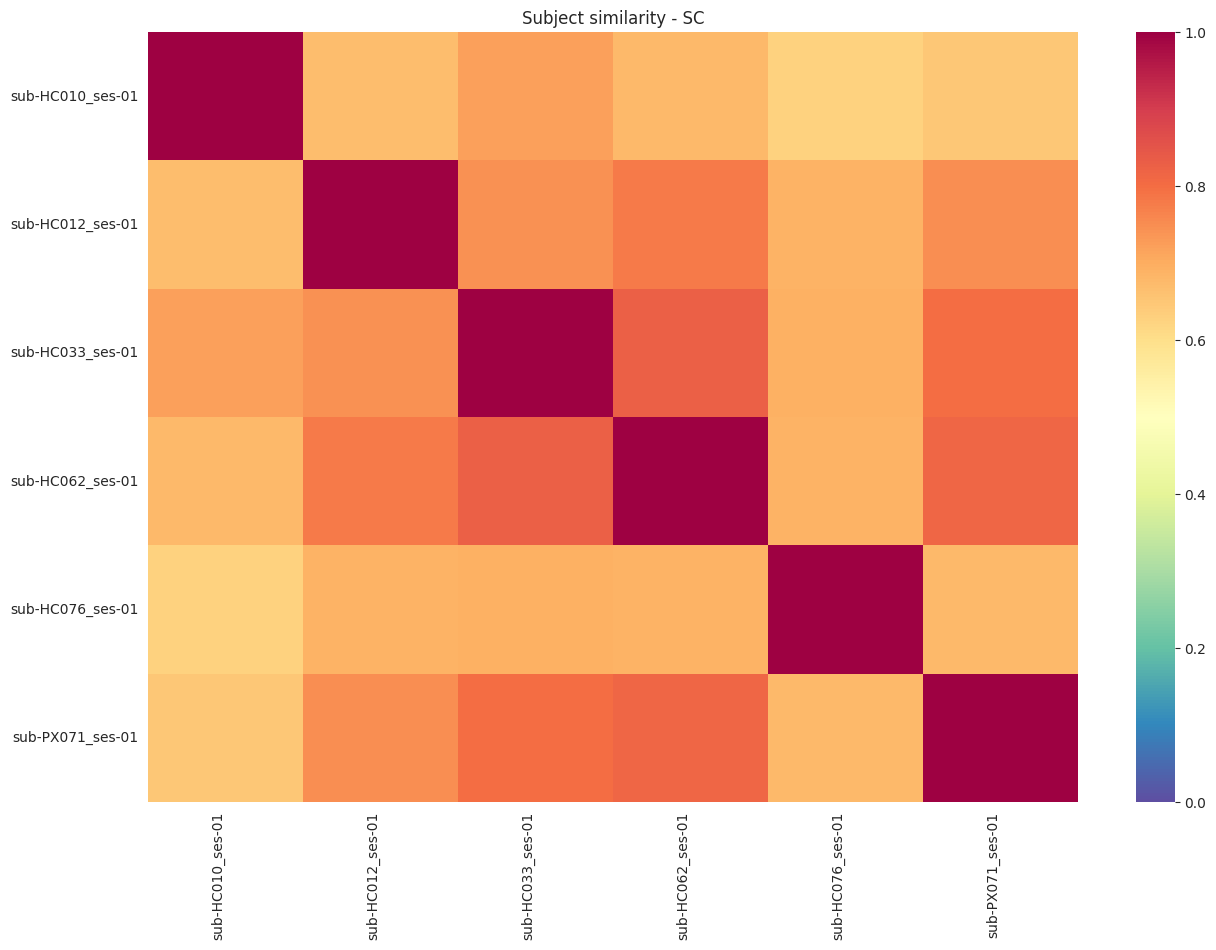

In [329]:
# get the BIDS ids
bids_ids = [elem.split('/')[0] + '_' + elem.split('/')[1] for elem in files]

cn_corr = np.corrcoef(np.mean(SC, axis=1).T)
plot_connectome(cn_corr, 'Subject similarity - SC', xlab=None, ylab=None, col='Spectral_r', vmin=0, vmax=1,
               yticklabels=bids_ids, xticklabels=bids_ids)

In [330]:
zscore_mtx(cn_corr)

(array([0.55754357, 0.60559195, 0.63051679, 0.63120817, 0.56214878,
        0.61541139]),
 array([-2.71235   , -1.91252442, -1.49761933, -1.48611033, -2.63569059,
        -1.74906767]))

# func

In [379]:
# Load all the connectomes
#acq='desc-se_task-rest_acq-AP_bold'
acq='desc-me_task-rest_bold'
files=sorted(glob.glob('sub-*/ses-*/func/'+acq+'/surf/*_atlas-schaefer-400_desc-FC.txt'))

CN = load_connectomes(files, Ndim, load_fc)

# Mean matrix across the z axis (subjects)
cn_mean = np.mean(CN, axis=2)
# Mean acros columns
cn_colM = np.sum(cn_mean, axis=1)
# map to labels
cn_surf = map_to_labels(cn_colM, labels_c69, fill=np.nan, mask=mask_c69)

/host/yeatman/local_raid/temporaryLocalProcessing/ipykernel_9539/1146255709.py:88: RuntimeWarning: divide by zero encountered in arctanh
  FCz = np.arctanh(FC)


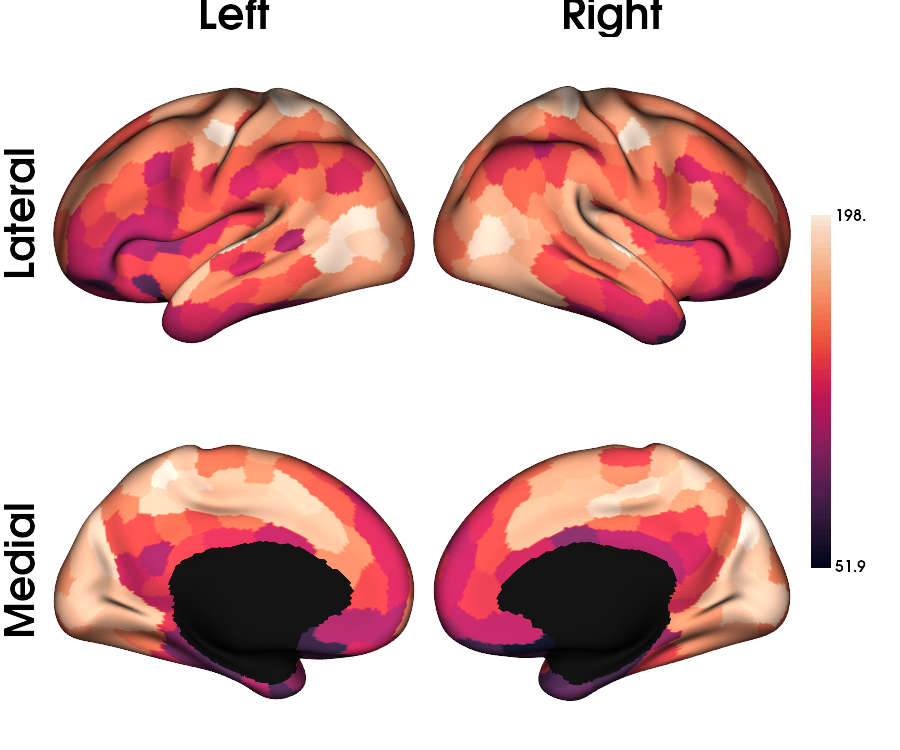

In [380]:
# Plot the mean connectome
plot_hemispheres(inf_lh, inf_rh, array_name=cn_surf, cmap='rocket', nan_color=(0, 0, 0, 1),
                      zoom=1.3, size=(900, 750), embed_nb=True,
                      color_bar='right', layout_style='grid', color_range='sym',
                      label_text={'left': ['Lateral', 'Medial'], 'top': ['Left', 'Right']},
                      screenshot=False, filename='/home/bic/rcruces/Desktop/FC_mean_schaefer-400.png')

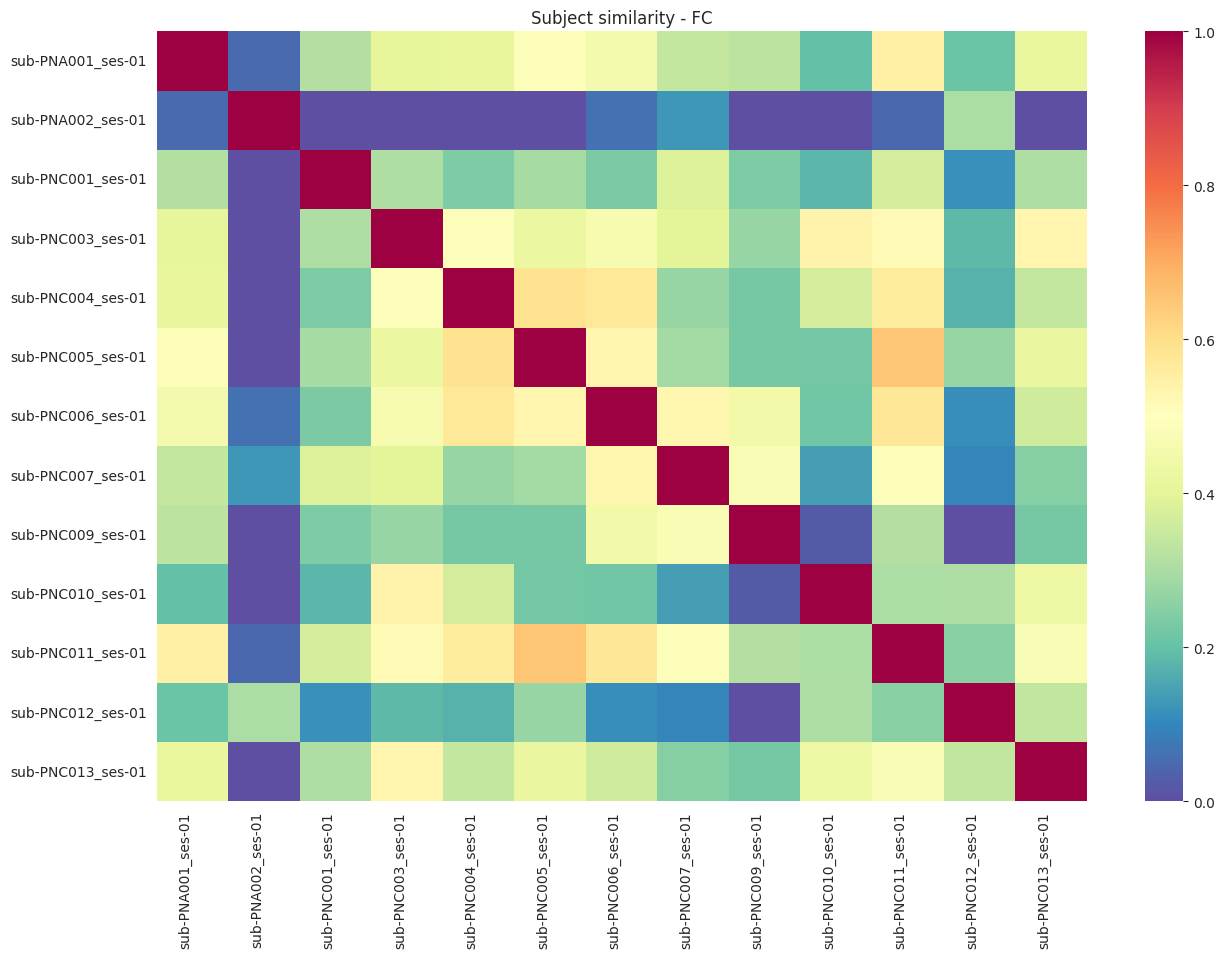

In [381]:
# get the BIDS ids
bids_ids = [elem.split('/')[0] + '_' + elem.split('/')[1] for elem in files]

cn_corr = np.corrcoef(np.mean(CN, axis=1).T)
plot_connectome(cn_corr, 'Subject similarity - FC', xlab=None, ylab=None, col='Spectral_r', vmin=0, vmax=1,
               yticklabels=bids_ids, xticklabels=bids_ids)

In [383]:
zscore_mtx(cn_corr)

(array([0.32041388, 0.02660865, 0.22645855, 0.3465359 , 0.32185676,
        0.3378367 , 0.35081235, 0.29067359, 0.2118451 , 0.22102434,
        0.39196056, 0.18081441, 0.31218272]),
 array([ 0.14148704, -1.48899788, -0.37992218,  0.2864523 ,  0.14949434,
         0.23817571,  0.31018467, -0.02355803, -0.46102013, -0.41007957,
         0.53853844, -0.63322634,  0.09580786]))

# MPC

In [2]:
# Load all the connectomes
acq='acq-T1map'
files=sorted(glob.glob('sub-*/ses-*/mpc/'+acq+'/*_atlas-schaefer-400_desc-MPC.txt'))

CN = load_connectomes(files, Ndim, load_mpc)

# Mean matrix across the z axis (subjects)
cn_mean = np.mean(CN, axis=2)
# Mean acros columns
cn_colM = np.mean(cn_mean, axis=1)
# map to labels
cn_surf = map_to_labels(cn_colM, labels_c69, fill=np.nan, mask=mask_c69)


NameError: name 'glob' is not defined

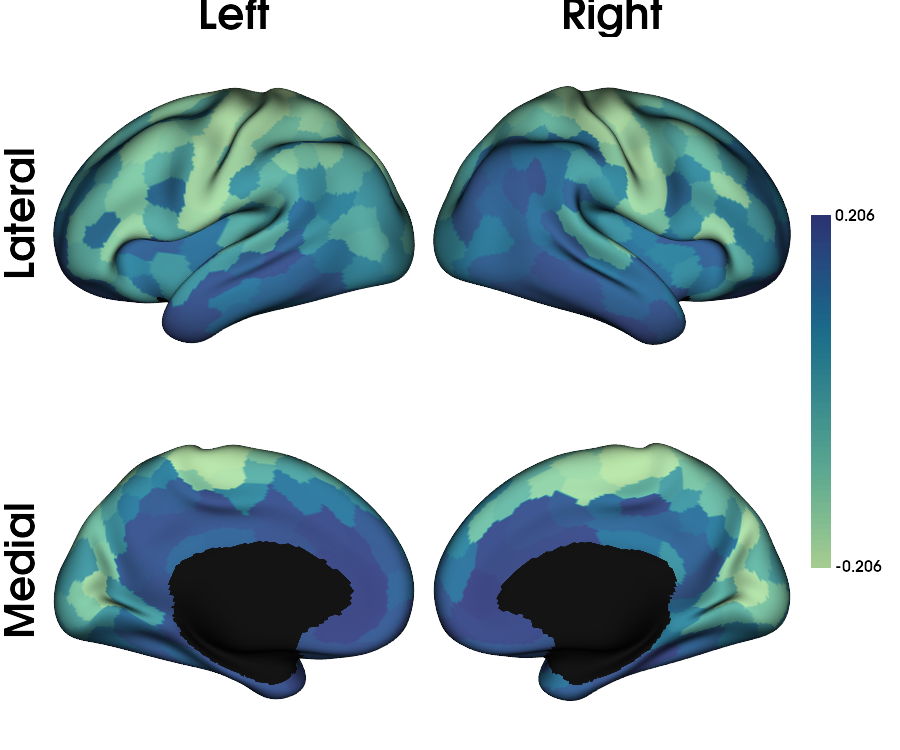

In [385]:
# Plot the mean SC
plot_hemispheres(inf_lh, inf_rh, array_name=cn_surf, cmap='crest', nan_color=(0, 0, 0, 1),
                      zoom=1.3, size=(900, 750), embed_nb=True,
                      color_bar='right', layout_style='grid', color_range='sym',
                      label_text={'left': ['Lateral', 'Medial'], 'top': ['Left', 'Right']},
                      screenshot=False, filename='/home/bic/rcruces/Desktop/SC_mean_schaefer-400.png')

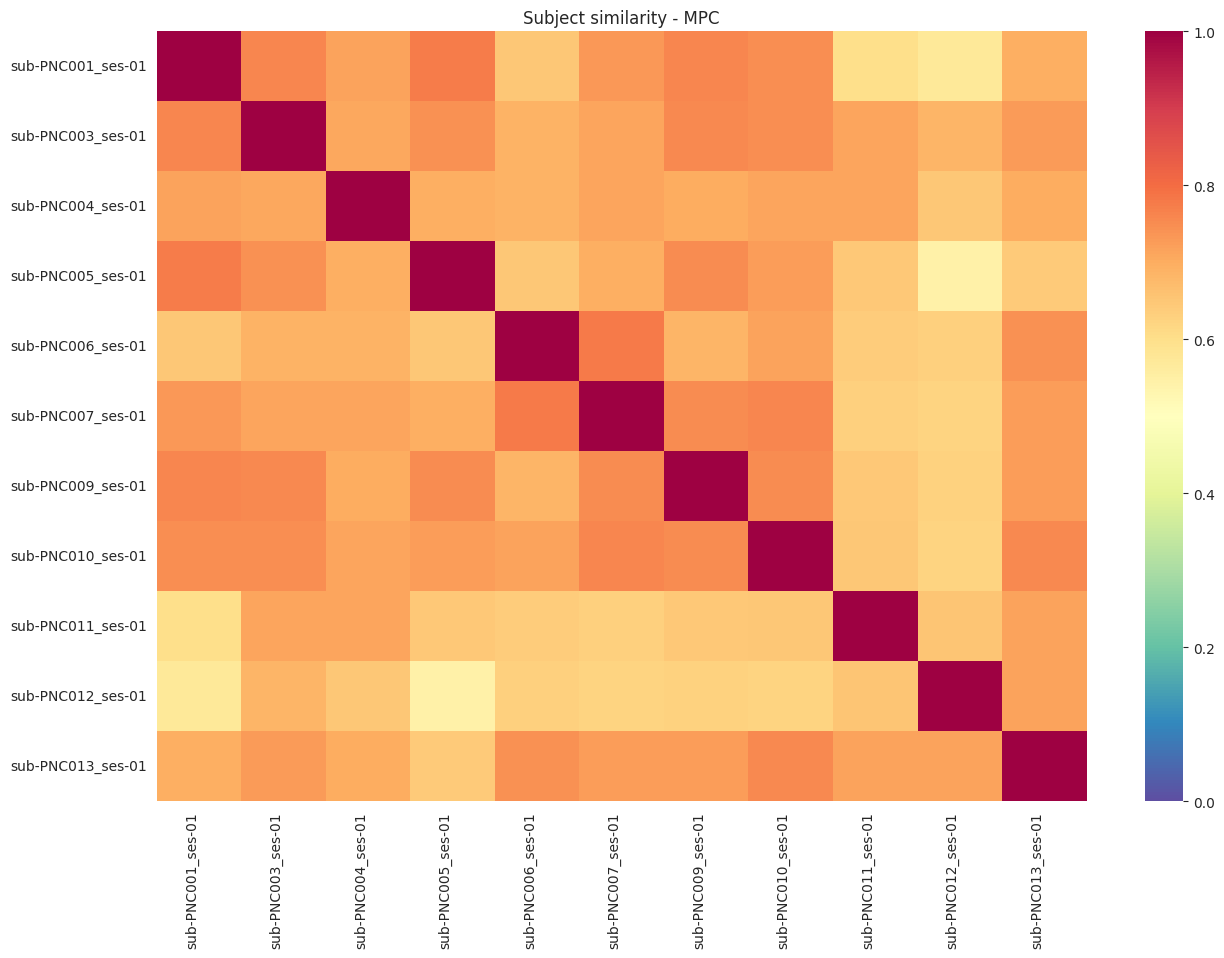

In [386]:
# get the BIDS ids
bids_ids = [elem.split('/')[0] + '_' + elem.split('/')[1] for elem in files]

cn_corr = np.corrcoef(np.mean(CN, axis=1).T)
plot_connectome(cn_corr, 'Subject similarity - MPC', xlab=None, ylab=None, col='Spectral_r', vmin=0, vmax=1,
               yticklabels=bids_ids, xticklabels=bids_ids)

# fsLR-5k MPC gradients

In [401]:
def load_5k(File, Ndim):
    # load the matrix
    mtx = np.loadtxt(File, dtype=float, delimiter=' ')
    
    # Mirror the matrix
    c5k = np.triu(mtx,1)+mtx.T
    
    return c5k

# Load all the connectomes
acq='acq-T1map'
files=sorted(glob.glob('sub-*/ses-*/mpc/'+acq+'/*_surf-fsLR-5k_desc-MPC.txt'))

CN = load_connectomes(files, 4842, load_5k)

# Mean matrix across the z axis (subjects)
cn_mean = np.mean(CN, axis=2)
# Mean acros columns
cn_colM = np.mean(cn_mean, axis=1)

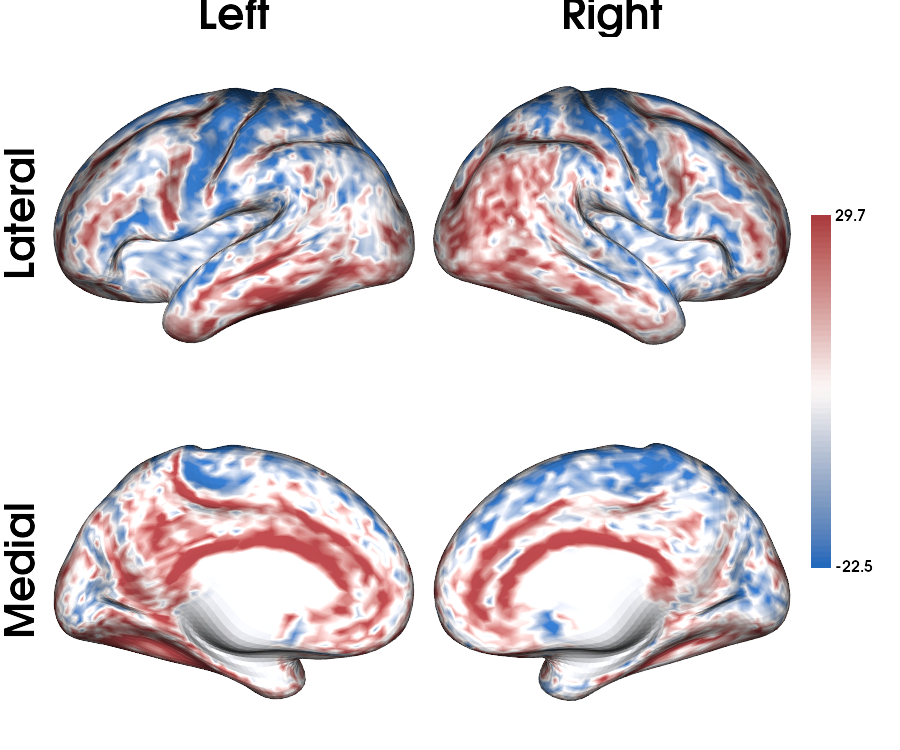

In [417]:
# Plot the mean SC
feat=cn_colM*1000
Range=(np.quantile(feat, 0.05), np.quantile(feat, 0.95))
plot_hemispheres(c5k_lhi, c5k_rhi, array_name=feat, cmap='vlag', nan_color=(0, 0, 0, 1),
                      zoom=1.3, size=(900, 750), embed_nb=True,
                      color_bar='right', layout_style='grid', color_range=Range,
                      label_text={'left': ['Lateral', 'Medial'], 'top': ['Left', 'Right']},
                      screenshot=False, filename='/home/bic/rcruces/Desktop/MPC_fsLR-5k.png')

In [421]:
cn_colM[cn_colM!=0]

array([-0.0244127 , -0.01223138,  0.0029443 , ...,  0.0149029 ,
        0.01643361,  0.018831  ])

In [415]:
cn_mean[~np.isfinite(cn_mean)] = 0
cn_mean[~np.isnan(cn_mean)] = 0
cn_mean[cn_mean==0] = np.finfo(float).eps

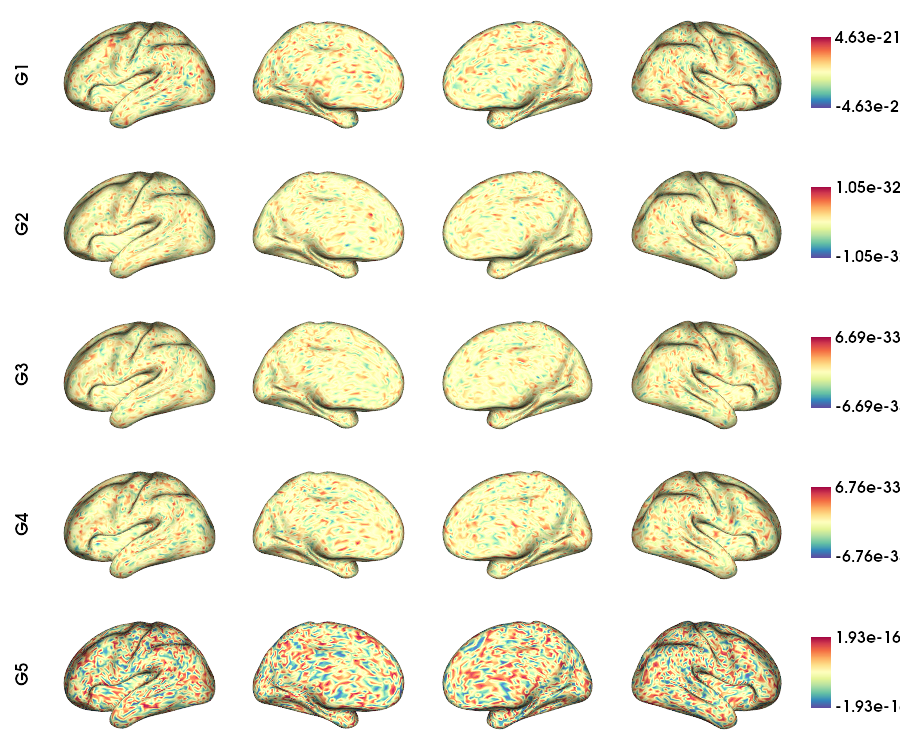

In [416]:
from brainspace.gradient import GradientMaps
# Calculate the gradients
Ngrads=5
MPCgm = GradientMaps(n_components=Ngrads, random_state=None, approach='dm', kernel='normalized_angle')
MPCgm.fit(cn_mean*1000, sparsity=0.9)

# Map gradients to original parcels
# other color 'RdYlBu_r'
grad = [None] * Ngrads
for i, g in enumerate(MPCgm.gradients_.T[0:Ngrads,:]):
    grad[i] = g

# plot the gradients
labels=['G'+str(x) for x in list(range(1,Ngrads+1))]
plot_hemispheres(c5k_lhi, c5k_rhi, array_name=grad, cmap='Spectral_r', nan_color=(0, 0, 0, 1),
  zoom=1.3, size=(900, 750), embed_nb=True, color_range='sym', color_bar='right', label_text={'left': labels},
  screenshot=False, filename='/home/bic/rcruces/Desktop/MPC_mean_fsLR-5k.png')  

In [1]:
cn_mean

NameError: name 'cn_mean' is not defined

(9682,)